In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import itertools
from collections import OrderedDict

In [14]:
def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing', 'Filtered']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))

bdir = "../results/tables/"
bdir = "/Users/english/code/kanpig_experiments/manuscript/full_analysis/reverse"
gt_data = pd.read_csv(bdir + "/all.gt_dist.table.txt", sep='\t')
inter_data = pd.read_csv(bdir + "/all.intersect.table.txt", sep='\t')
neigh_data = pd.read_csv(bdir + "/all.neighbor.table.txt", sep='\t')
svtype_data = pd.read_csv(bdir + "/all.svtype.table.txt", sep='\t')

tr_gt_data = pd.read_csv(bdir + "/tr.gt_dist.table.txt", sep='\t')
tr_inter_data = pd.read_csv(bdir + "/tr.intersect.table.txt", sep='\t')
tr_neigh_data = pd.read_csv(bdir + "/tr.neighbor.table.txt", sep='\t')
tr_svtype_data = pd.read_csv(bdir + "/tr.svtype.table.txt", sep='\t')

ntr_gt_data = pd.read_csv(bdir + "/non_tr.gt_dist.table.txt", sep='\t')
ntr_inter_data = pd.read_csv(bdir + "/non_tr.intersect.table.txt", sep='\t')
ntr_neigh_data = pd.read_csv(bdir + "/non_tr.neighbor.table.txt", sep='\t')
ntr_svtype_data = pd.read_csv(bdir + "/non_tr.svtype.table.txt", sep='\t')

# Overview Table

In [47]:
inter_data['Filtered'] = 0
add_summary(inter_data, True)

In [60]:
view = inter_data[(inter_data['experiment'] == 'tm')
                 & (inter_data['coverage'] == '32x')]

In [49]:
view.groupby(['program'])['GT Concordance'].describe()

,count,mean,std,min,25%,50%,75%,max
program,,,,,,,,
cutesv,47.0,0.127859,0.007089,0.117417,0.120692,0.132110,0.134396,0.138082
kanpig,47.0,0.866194,0.014268,0.814881,0.856844,0.872166,0.877981,0.881915
sniffles,47.0,0.122663,0.006645,0.112215,0.116126,0.126466,0.128530,0.131859
svjedi,9.0,0.421779,0.015886,0.400650,0.411981,0.415282,0.433649,0.445155


In [50]:
view.groupby(['program'])[['GT Concordance', 'TP-base', 'TP-comp', 'FP', 'FN', 'precision', 'recall', 'f1']].mean()

,GT Concordance,TP-base,TP-comp,FP,FN,precision,recall,f1
program,,,,,,,,
cutesv,0.127859,22927.808511,22981.404255,104494.978723,1051.468085,0.180129,0.956104,0.303015
kanpig,0.866194,22671.319149,21640.234043,597.851064,1129.340426,0.973004,0.952527,0.962648
sniffles,0.122663,24885.702128,24985.723404,121393.510638,762.553191,0.170554,0.970223,0.290001
svjedi,0.421779,24410.888889,24620.222222,19537.777778,336.333333,0.557030,0.986364,0.711837


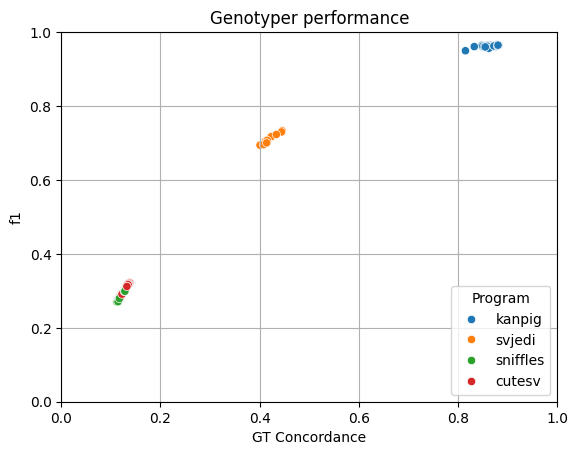

In [65]:
p = sb.scatterplot(data=view, x='GT Concordance', y='f1', hue='program')
p.set(xlim=(0,1), ylim=(0,1), title="Genotyper performance")
plt.legend(loc="lower right", title="Program")
plt.grid(axis='both')

# Genotype Distribution

In [35]:
import joblib
b = joblib.load("/Users/english/code/kanpig_experiments/manuscript/explore_section09/gtcnts.jl")
mean = np.sum(b, axis=1)
mean[0] = mean[3]
mean[3] = 0
mean = mean[:4]

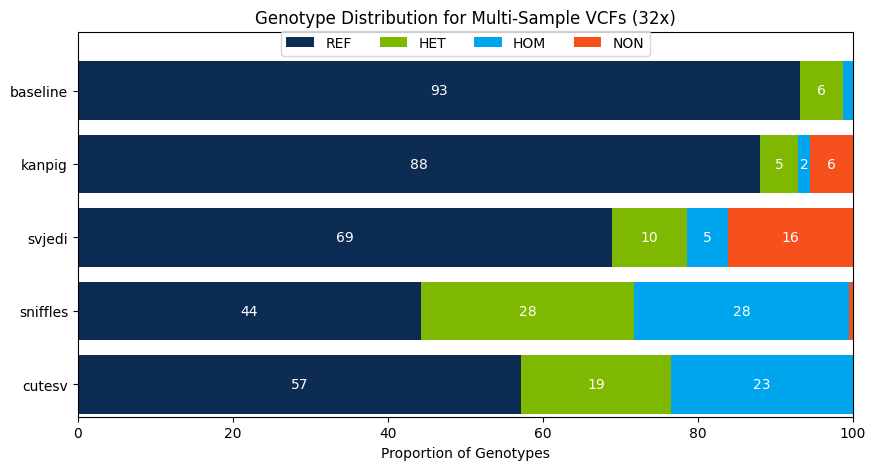

In [66]:
tests = ['cutesv', 'sniffles', 'svjedi', 'kanpig', 'baseline']

m_data = OrderedDict()

# Bottom up order
view = gt_data[(gt_data['coverage'] == '32x') 
               & (gt_data['technology'] == 'pac')
              & (gt_data['experiment'].isin(['tm', 'truth']))]
for i in tests:
    m_data[(i, 'pac')] = view[view['program'] == i][['REF', 'HET', 'HOM', 'NON']].sum()

m_data[('baseline', 'pac')] = mean
#data[('exbaseline', '')] = [17937331 , 1079127, 233567, 0]

# Normalize the data by percentages for each test and observation
normalized_data = OrderedDict()
y_labels = []
y_super = []
for key, counts in m_data.items():
    total = np.sum(counts)
    normalized_data[key] = (counts / total) * 100

    y_labels.append(key[0])
    if key[1] not in y_super:
        y_super.append(key[1])

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = .6
y_positions = []

# Define colors for each category
colors = ['#0D2C54', '#7FB800', '#00A6ED', '#F6511D']
categories = ['REF', 'HET', 'HOM', 'NON']

# Plot each test and observation
y_pos = -.75
for i, ((test, observation), counts) in enumerate(normalized_data.items()):
    y_pos += .75
    y_positions.append(y_pos)
    left = 0
    for j, (count, color, category) in enumerate(zip(counts, colors, categories)):
        ax.barh(y_pos, count, left=left, color=color, height=bar_width, label=category if y_pos == 0 else "")
        if count > 1.5:  # Only add text if the percentage is greater than 5
            ax.text(left + count / 2, y_pos, f'{count:.0f}', va='center', ha='center', color='white')
        left += count

# Adding labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
ax.set_ylim((-.33, max(y_positions) + .6))
ax.set_xlabel('Proportion of Genotypes')
ax.set_title('Genotype Distribution for Multi-Sample VCFs (32x)')

# Adjusting the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(categories)], labels[:len(categories)], 
          loc="upper center", bbox_to_anchor=(0.5, 1.021), ncol=len(categories))
#sb.despine(fig)
plt.show()


In [40]:
pd.DataFrame(normalized_data)

,cutesv,sniffles,svjedi,kanpig,baseline
,pac,pac,pac,pac,pac
REF,57.214676,44.231856,68.905046,88.046906,93.180819
HET,19.301544,27.542972,9.688455,4.881292,5.605847
HOM,23.483781,27.760796,5.331147,1.534727,1.213333
NON,0.000000,0.464376,16.075351,5.537075,0.000000


# Number of Neighbors

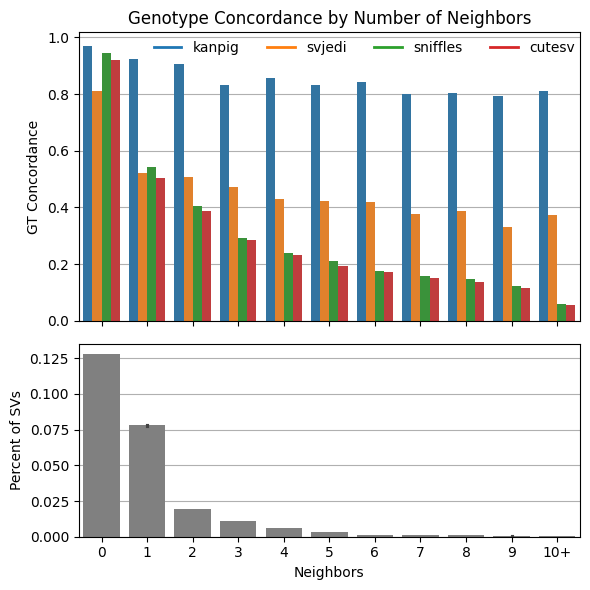

In [17]:
add_summary(neigh_data)

yvar = "GT Concordance"
experiment = "tm"
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                              gridspec_kw={'height_ratios': [3, 2]})  # figsize is (width, height)

view = neigh_data[(neigh_data['experiment'] == experiment) 
                  & (neigh_data['technology'] == 'pac')
                 & (neigh_data['coverage'] == '32x')]
lineplot = sb.barplot(data=view, ax=ax1,
                       x="num_neigh", y=yvar, 
                       hue="program",
                      hue_order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                     zorder=2)

hue_labels = ['kanpig', 'svjedi', 'sniffles', 'cutesv']
#styles = ['solid', 'dashed']
#style_labels = neigh_data['Technology'].unique()

# Get handles and labels for both hue and style
handles, _ = lineplot.get_legend_handles_labels()

# Create legend elements
hue_elements = [plt.Line2D([0], [0], color=sb.color_palette()[i], lw=2) for i in range(len(hue_labels))]
#style_elements = [plt.Line2D([0], [0], color='black', linestyle=styles[i], lw=2) for i in range(len(style_labels))]

# Combine elements
legend_elements = hue_elements #+ style_elements
legend_labels = list(hue_labels) #+ list(style_labels)

lineplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
lineplot.set_xticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"])
lineplot.set(title="Genotype Concordance by Number of Neighbors", 
             xlabel="", 
             ylabel="GT Concordance")
# Create custom legend
ax1.legend(legend_elements, legend_labels, title='', ncol=4, loc='upper right', 
           bbox_to_anchor=(1.015, 1.015), frameon=False)
ax1.grid(axis='y', zorder=1)

# This is redundantly added...
baseline = neigh_data[(neigh_data['technology'] == 'pac')
                      & (neigh_data['experiment'] == 'ts')
                      & (neigh_data['coverage'] == '32x')
                      & (neigh_data['sample'] == 'HG002_n')]
pct = baseline[['num_neigh', 'Total Calls']].copy()
pct['percent of calls'] = pct['Total Calls'] / pct['Total Calls'].sum()
hist = sb.barplot(data=pct, x="num_neigh", y="percent of calls", zorder=2, color='#808080')
hist.set(ylabel="Percent of SVs", xlabel="Neighbors")
ax2.grid(axis='y', zorder=1)
fig.tight_layout()

In [4]:
neigh_data.columns

Index(['Concordant', 'Discordant', 'Missing', 'Filtered', 'TP', 'FP', 'TN',
       'FN', 'num_neigh', 'program', 'sample', 'technology', 'coverage',
       'experiment', 'Total Calls', 'Total Genotyped', 'Missing Rate',
       'GT Concordance', 'compP', 'baseP', 'compN', 'baseN', 'ppv', 'tpr',
       'tnr', 'npv', 'acc', 'ba', 'f1'],
      dtype='object')

# Overall Plot

In [22]:
YMIN,YMAX = 0,1
def add_summary(data, with_as=False):
    """
    Add summary stats to a dataframe
    """
    e = "as_" if with_as else ""
    data['Total Calls'] = data[['Concordant', 'Discordant', 'Missing', 'Filtered']].sum(axis=1)
    data['Total Genotyped'] = data['Total Calls'] - data['Missing']
    data['Missing Rate'] = data['Missing'] / data['Total Genotyped']
    data['GT Concordance'] = data['Concordant'] / data['Total Genotyped']
    data[f'{e}compP'] = data[f'{e}TP'] + data[f'{e}FP']
    data[f'{e}baseP'] = data[f'{e}TP'] + data[f'{e}FN']
    data[f'{e}compN'] = data[f'{e}TN'] + data[f'{e}FN']
    data[f'{e}baseN'] = data[f'{e}TN'] + data[f'{e}FP']
    data[f'{e}ppv'] = data[f'{e}TP'] / data[f'{e}compP']
    data[f'{e}tpr'] = data[f'{e}TP'] / data[f'{e}baseP']
    data[f'{e}tnr'] = data[f'{e}TN'] / data[f'{e}baseN']
    data[f'{e}npv'] = data[f'{e}TN'] / data[f'{e}compN']
    data[f'{e}acc'] = (data[f'{e}TP'] + data[f'{e}TN']) / (data[f'{e}baseP'] + data[f'{e}baseN'])
    data[f'{e}ba'] = (data[f'{e}tpr'] + data[f'{e}tnr']) / 2
    data[f'{e}f1'] = 2 * ((data[f'{e}ppv'] * data[f'{e}tpr']) / (data[f'{e}ppv'] + data[f'{e}tpr']))
    
def plot_gtconcordance_barplot(subset, ax, title="Genotype Concordance"):
    p = sb.barplot(data=subset, x="program", y="GT Concordance", hue="coverage", 
                   hue_order=['32x', '16x', '8x'], ax=ax, zorder=2)
    p.set(title=title, ylabel="Overall GT Concordance")

    categories = subset['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='Coverage', loc='upper right')
    legend.get_frame().set_edgecolor('white')
    
def plot_typestrat(subset_a, subset_b, ax1, ax2):
    """
    A is TRs, B is Non-TRs
    """
    p = sb.barplot(data=subset_a, x="program", y="GT Concordance", hue="svtype", 
                   hue_order=['DEL', 'INS'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax1)


    categories = subset_a['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax1.grid(axis='y', zorder=1)
    legend = p.legend(frameon=True, title='SV Type', ncol=1, loc='upper right')
    legend.get_frame().set_edgecolor('white')
    ax1.set(ylabel="SVTYPE GT Concordance")

    ## Second half
    p = sb.barplot(data=subset_b, x="program", y="GT Concordance", hue="TR", 
                   hue_order=['inside', 'outside'], order=['kanpig', 'svjedi', 'sniffles', 'cutesv'],
                   zorder=2, ax=ax2)


    p.set(xlabel="Program", ylabel="TR GT Concordance")

    categories = subset_a['program'].unique()
    num_categories = len(categories)

    # Alternate shading for every other category
    for i in range(0, num_categories, 2):
        p.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)

    # Adjust x-axis limits if needed
    p.set_xlim(-0.5, num_categories - 0.5)
    p.set_ylim(YMIN, YMAX)
    ax2.grid(axis='y', zorder=1)
    #legend = p.legend(frameon=True, title='SV Type', loc='upper right')
    #legend.get_frame().set_edgecolor('white')
    


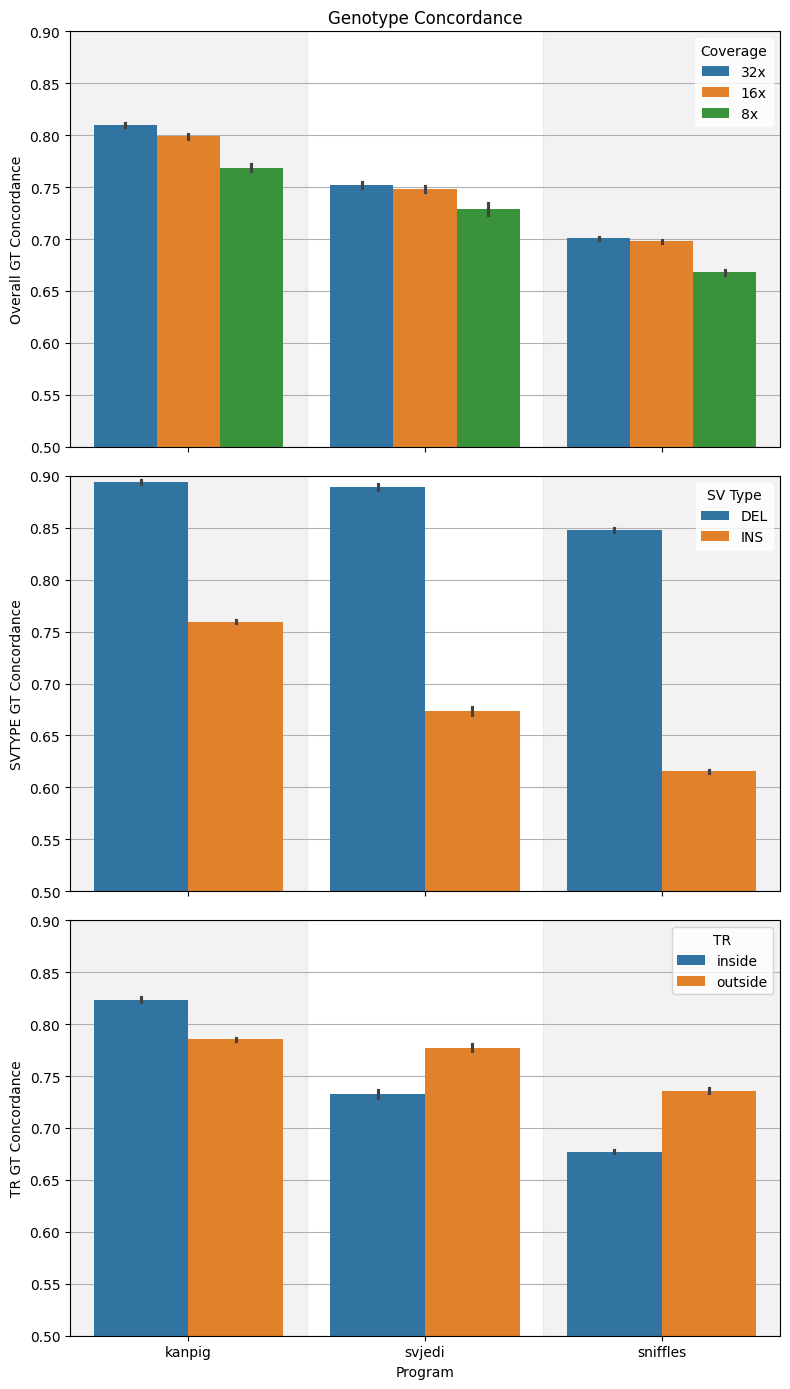

In [12]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'tm'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Genotype Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c])

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()


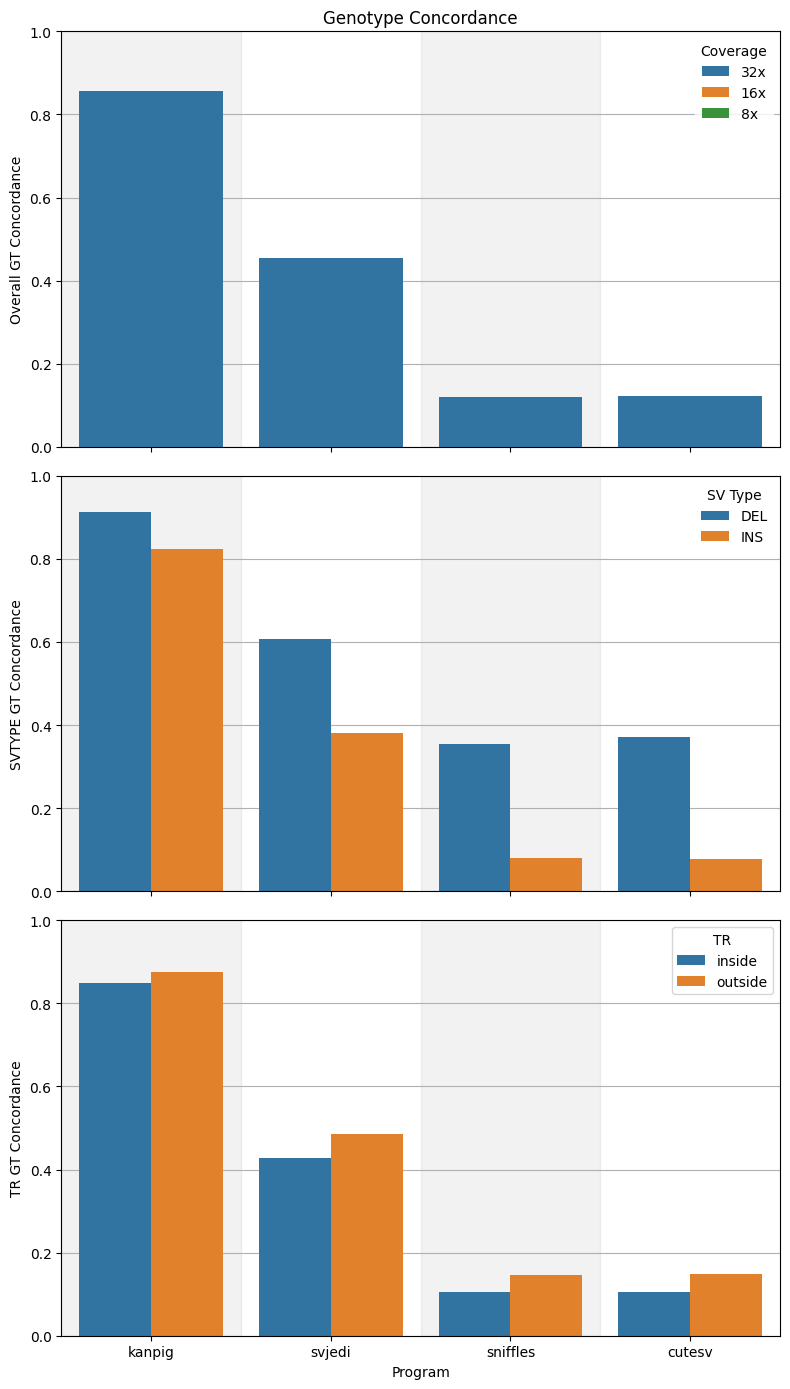

In [23]:
add_summary(svtype_data)
add_summary(tr_svtype_data)
add_summary(ntr_svtype_data)

exp = 'tm'

view = svtype_data[(svtype_data['svtype'] == 'TOT')
                    & (svtype_data['experiment'] == exp)
                    & (svtype_data['technology'] == 'pac')]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 14))

plot_gtconcordance_barplot(view, ax1, "Genotype Concordance")

a = svtype_data[(tr_svtype_data['svtype'] != 'TOT')
                   & (svtype_data['experiment'] == exp)
                   & (svtype_data['technology'] == 'pac')
                   & (svtype_data['coverage'] == '32x')]

b = tr_svtype_data[(tr_svtype_data['svtype'] == 'TOT')
                   & (tr_svtype_data['experiment'] == exp)
                   & (tr_svtype_data['technology'] == 'pac')
                   & (tr_svtype_data['coverage'] == '32x')].copy()
b['TR'] = 'inside'
c = ntr_svtype_data[(ntr_svtype_data['svtype'] == 'TOT')
                   & (ntr_svtype_data['experiment'] == exp)
                   & (ntr_svtype_data['technology'] == 'pac')
                   & (ntr_svtype_data['coverage'] == '32x')].copy()
c['TR'] = 'outside'
d = pd.concat([b, c])

plot_typestrat(a, d, ax2, ax3)
fig.tight_layout()
plt.show()
